微调步骤

    在预训练卷积基上添加自定义层
    冻结卷积基上所有层
    训练添加的分类层
    解冻卷积基的一部分层(习惯上解冻靠近输出部分的卷积)
    联合训练解冻卷积层和添加自定义层

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import os
import shutil
import matplotlib.pyplot as plt
from   torchvision import transforms
%matplotlib inline

##### 读取数据集

In [2]:
base_dir = r'./data/FourWeather/'
train_dir= os.path.join(base_dir,"train")
test_dir = os.path.join(base_dir,"test")

In [3]:
train_transform = transforms.Compose([                                # 将图片在输入管道上做出一定变化，完成数据增强
    transforms.Resize(224),    
    transforms.RandomCrop(192),           
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ColorJitter(brightness=0.5),
    transforms.ColorJitter(contrast=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])

test_transform  = transforms.Compose([
    transforms.Resize((192,192)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])

In [4]:
BATCH_SIZE = 8

In [5]:
train_ds = torchvision.datasets.ImageFolder(
    os.path.join(base_dir,"train"),
    transform = train_transform
)

test_ds  = torchvision.datasets.ImageFolder(
    os.path.join(base_dir,"test"),
    transform = test_transform
)

train_dl = torch.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
test_dl  = torch.utils.data.DataLoader(test_ds,batch_size=BATCH_SIZE,shuffle=True)

In [6]:
class_to_id = train_ds.class_to_idx
id_to_class = dict((v,k) for k,v in train_ds.class_to_idx.items())

##### 创建模型

In [7]:
model = torchvision.models.resnet101(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to C:\Users\20613/.cache\torch\hub\checkpoints\resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

###### 修改预训练模型

In [8]:
for param in model.parameters():
    param.requires_grad = False
    
in_fc    = model.fc.in_features
model.fc = nn.Linear(in_fc,4)

###### 迁移训练模型到GPU并定义优化/损失函数

In [9]:
model   = model.to("cuda")
optim   = torch.optim.Adam(model.fc.parameters(),lr=0.001)            
epoches = 20
loss_fn = nn.CrossEntropyLoss()

In [10]:
from torch.optim import lr_scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optim, step_size=7, gamma=0.1) 

###### 定义fit函数

In [11]:
def fit(model,trainloader,testloader,epoch):
    correct = 0       # 记录正确率
    total   = 0       # 记录训练样本总数量
    running_loss = 0
    
    model.train()     # 设置为训练模式 表示DropOut会起作用
    
    for x,y in trainloader:
        x,y    = x.to("cuda"),y.to("cuda")
        y_pred = model(x)
        loss   = loss_fn(y_pred,y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        with torch.no_grad():
            y_pred = torch.argmax(y_pred,dim=1)
            correct+=(y_pred == y).sum().item()
            total  += y.size(0)
            running_loss += loss.item()
    
    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset) # 得到每一个样本在本epoch下的平均loss
    epoch_acc  = correct / total                         # 得到整个样本的平均预测正确率
    
    test_correct      = 0        # 记录正确率
    test_total        = 0        # 记录训练样本总数量
    test_running_loss = 0
    
    model.eval()                 # 将模型修改为预测模式 表示DropOut失效 注意在验证数据集上不需要进行Dropout
    
    with torch.no_grad():
        for x,y in testloader:
            x,y    = x.to("cuda"),y.to("cuda")
            y_pred = model(x)
            loss   = loss_fn(y_pred,y)
            y_pred = torch.argmax(y_pred,dim=1)
            test_correct+=(y_pred == y).sum().item()
            test_total  += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset) # 得到每一个样本在本epoch下的平均loss
    epoch_test_acc  = test_correct / test_total                   # 得到整个样本的平均预测正确率
    
    print(
            "epoch:","\t",epoch,"\t",
            "loss: ","\t",round(epoch_loss,3),"\t",
            "accuracy: ","\t",round(epoch_acc,3),"\t",
            "test_loss: ","\t",round(epoch_test_loss,3),"\t",
            "test_accuracy: ","\t",round(epoch_test_acc,3),"\t"
        )
    return epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc

In [12]:
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

#### 训练模型

In [13]:
for epoch in range(epoches):
    epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc = fit(model,train_dl,test_dl,epoch)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch: 	 0 	 loss:  	 0.092 	 accuracy:  	 0.729 	 test_loss:  	 0.035 	 test_accuracy:  	 0.924 	
epoch: 	 1 	 loss:  	 0.055 	 accuracy:  	 0.847 	 test_loss:  	 0.032 	 test_accuracy:  	 0.911 	
epoch: 	 2 	 loss:  	 0.044 	 accuracy:  	 0.881 	 test_loss:  	 0.025 	 test_accuracy:  	 0.942 	
epoch: 	 3 	 loss:  	 0.041 	 accuracy:  	 0.879 	 test_loss:  	 0.022 	 test_accuracy:  	 0.942 	
epoch: 	 4 	 loss:  	 0.043 	 accuracy:  	 0.878 	 test_loss:  	 0.037 	 test_accuracy:  	 0.898 	
epoch: 	 5 	 loss:  	 0.036 	 accuracy:  	 0.884 	 test_loss:  	 0.027 	 test_accuracy:  	 0.938 	
epoch: 	 6 	 loss:  	 0.038 	 accuracy:  	 0.883 	 test_loss:  	 0.036 	 test_accuracy:  	 0.916 	
epoch: 	 7 	 loss:  	 0.032 	 accuracy:  	 0.908 	 test_loss:  	 0.024 	 test_accuracy:  	 0.942 	
epoch: 	 8 	 loss:  	 0.031 	 accuracy:  	 0.909 	 test_loss:  	 0.025 	 test_accuracy:  	 0.938 	
epoch: 	 9 	 loss:  	 0.028 	 accuracy:  	 0.921 	 test_loss:  	 0.027 	 test_accuracy:  	 0.924 	
epoch: 	 1

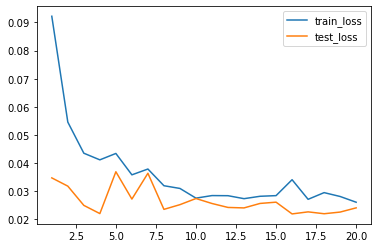

In [14]:
plt.plot(range(1,epoches+1),train_loss,label = "train_loss")
plt.plot(range(1,epoches+1),test_loss,label = "test_loss")
plt.legend()

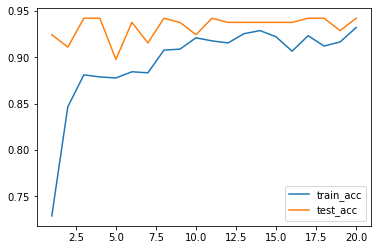

In [15]:
plt.plot(range(1, epoches+1), train_acc, label='train_acc')
plt.plot(range(1, epoches+1), test_acc, label='test_acc')
plt.legend()

##### 微调模型(本操作只能在训练结束的时候进行)

In [16]:
for param in model.parameters():                                # 首先解冻结所有的可训练参数
    param.requires_grad = True

In [17]:
extend_epoch = 30
optim        = torch.optim.Adam(model.parameters(),lr=0.00001) # 目前需要优化全部参数 训练速率调低
train_loss   = []
train_acc    = []
test_loss    = []
test_acc     = []

In [18]:
for epoch in range(extend_epoch):
    epoch_loss,epoch_acc,epoch_test_loss,epoch_test_acc = fit(model,train_dl,test_dl,epoch)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_acc)

epoch: 	 0 	 loss:  	 0.028 	 accuracy:  	 0.916 	 test_loss:  	 0.019 	 test_accuracy:  	 0.951 	
epoch: 	 1 	 loss:  	 0.021 	 accuracy:  	 0.947 	 test_loss:  	 0.016 	 test_accuracy:  	 0.951 	
epoch: 	 2 	 loss:  	 0.024 	 accuracy:  	 0.932 	 test_loss:  	 0.02 	 test_accuracy:  	 0.947 	
epoch: 	 3 	 loss:  	 0.016 	 accuracy:  	 0.967 	 test_loss:  	 0.017 	 test_accuracy:  	 0.956 	
epoch: 	 4 	 loss:  	 0.02 	 accuracy:  	 0.946 	 test_loss:  	 0.018 	 test_accuracy:  	 0.951 	
epoch: 	 5 	 loss:  	 0.013 	 accuracy:  	 0.971 	 test_loss:  	 0.018 	 test_accuracy:  	 0.942 	
epoch: 	 6 	 loss:  	 0.015 	 accuracy:  	 0.957 	 test_loss:  	 0.015 	 test_accuracy:  	 0.956 	
epoch: 	 7 	 loss:  	 0.013 	 accuracy:  	 0.97 	 test_loss:  	 0.021 	 test_accuracy:  	 0.951 	
epoch: 	 8 	 loss:  	 0.011 	 accuracy:  	 0.97 	 test_loss:  	 0.018 	 test_accuracy:  	 0.956 	
epoch: 	 9 	 loss:  	 0.01 	 accuracy:  	 0.971 	 test_loss:  	 0.018 	 test_accuracy:  	 0.964 	
epoch: 	 10 	 l

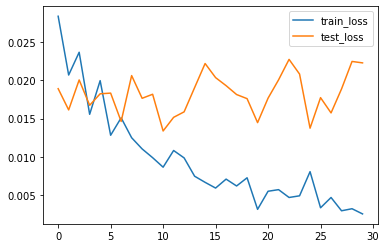

In [27]:
plt.plot(range(len(train_loss)),train_loss,label = "train_loss")
plt.plot(range(len(test_loss)),test_loss,label = "test_loss")
plt.legend()

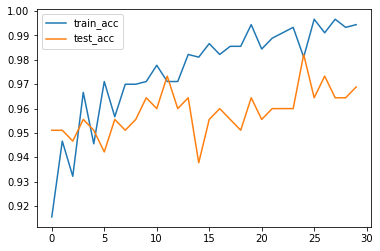

In [29]:
plt.plot(range(len(train_acc)), train_acc, label='train_acc')
plt.plot(range(len(test_acc)), test_acc, label='test_acc')
plt.legend()